In [1]:
import os
import signal
import gunicorn.app.base
from multiprocessing import Process
from contextlib import contextmanager

HOST, PORT = "127.0.0.1", "8080"

class BenchmarkApplication(gunicorn.app.base.BaseApplication):

    def __init__(self, app, worker_class, threads):
        self.worker_class = worker_class
        self.threads = threads
        self.application = app
        super().__init__()

    def load_config(self):
        self.cfg.set("bind", f"{HOST}:{PORT}")
        self.cfg.set("workers", 2)
        self.cfg.set("worker_class", self.worker_class)
        self.cfg.set("threads", self.threads)
        
    def load(self):
        return self.application

def run(app_func, worker, threads):
    app = app_func()
    BenchmarkApplication(app, worker, threads).run()
    
@contextmanager
def app_running(app_func, worker, threads=1):
    p = Process(target=lambda: run(app_func, worker, threads))
    p.start()
    time.sleep(1)
    print("allowed sleep")
    yield 
    os.kill(p.pid, signal.SIGINT)
    print("kill sent")
    p.join(timeout=5)

In [4]:
%matplotlib inline
import time
from multiprocessing import Process

class Stats:
    def __init__(self):
        self.request_latencies = []
        self.timed_out = 0
        self.elapsed_time = 0

async def fetch(stats, session, url):
    start_time = time.time()
    try:
        async with session.get(url) as response:
            await response.text()
    except:
        stats.timed_out += 1
    else:
        elapsed_time = time.time() - start_time
        stats.request_latencies.append(elapsed_time)

import aiohttp
TOTAL_COUNT = 5000
MAX_CONNECTIONS = 200

async def benchmark(root="http://localhost:8080/"):
    url = root + "foo"
    stats = Stats()
    start_time = time.time()
    conn = aiohttp.TCPConnector(limit=MAX_CONNECTIONS)
    async with aiohttp.ClientSession(connector=conn) as session:
        task_list = []
        for i in range(TOTAL_COUNT):
            task_list.append(fetch(stats, session, url))
        await asyncio.gather(*task_list)
    elapsed_time = time.time() - start_time
    stats.elapsed_time = elapsed_time
    return stats

In [ ]:
from aiohttp import web
import asyncio

def create_aiohttp_app():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    async def handle(request):
        name = request.match_info.get('name', "Anonymous")
        await asyncio.sleep(0.1)
        text = "Hello, " + name
        return web.Response(text=text)

    aiohttp_app = web.Application()
    aiohttp_app.router.add_get('/', handle)
    aiohttp_app.router.add_get('/{name}', handle)
    return aiohttp_app
    
import asyncio
loop = asyncio.get_event_loop()
with app_running(create_aiohttp_app, "aiohttp.worker.GunicornWebWorker"):
     stats = loop.run_until_complete(benchmark())
    
import matplotlib.pyplot as plt

print(stats.elapsed_time)
plt.hist(stats.request_latencies, bins=100)

[2017-07-05 21:41:30 -0700] [7641] [INFO] Starting gunicorn 19.7.1
[2017-07-05 21:41:30 -0700] [7641] [INFO] Listening at: http://127.0.0.1:8080 (7641)
[2017-07-05 21:41:30 -0700] [7641] [INFO] Using worker: aiohttp.worker.GunicornWebWorker
[2017-07-05 21:41:30 -0700] [7642] [INFO] Booting worker with pid: 7642
[2017-07-05 21:41:30 -0700] [7643] [INFO] Booting worker with pid: 7643


allowed sleep


[2017-07-05 21:40:45 -0700] [7625] [INFO] Starting gunicorn 19.7.1
[2017-07-05 21:40:45 -0700] [7625] [INFO] Listening at: http://127.0.0.1:8080 (7625)
[2017-07-05 21:40:45 -0700] [7625] [INFO] Using worker: threads
[2017-07-05 21:40:45 -0700] [7626] [INFO] Booting worker with pid: 7626
[2017-07-05 21:40:45 -0700] [7629] [INFO] Booting worker with pid: 7629


allowed sleep


[2017-07-05 21:41:04 -0700] [7625] [INFO] Handling signal: int
[2017-07-05 21:41:04 -0700] [7626] [INFO] Worker exiting (pid: 7626)
[2017-07-05 21:41:04 -0700] [7629] [INFO] Worker exiting (pid: 7629)


kill sent


[2017-07-05 21:41:04 -0700] [7625] [INFO] Shutting down: Master


18.032105922698975


(array([ 40.,  40.,  40.,  23.,  37.,  40.,  32.,  28.,  40.,  40.,  22.,
         38.,  36.,  19.,  22.,  23.,  17.,  11.,  11.,   7.,   8.,   8.,
          7.,   5.,   8.,   7.,   5.,   8.,   7.,   6.,   7.,   8.,   5.,
          7.,   8.,   6.,   9.,   5.,   5.,   5.,   4.,   6.,   5.,   4.,
          6.,   5.,   4.,   6.,   4.,   5.,   6.,   4.,   5.,   6.,   4.,
          5.,   6.,   5.,   5.,   5.,   4.,   6.,   5.,   4.,   6.,   5.,
          4.,   6.,   5.,   4.,   6.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   4.,   6.,   5.,   5.,   5.,   5.,
          5.]), array([  0.42265677,   0.59651399,   0.7703712 ,   0.94422842,
          1.11808563,   1.29194285,   1.46580006,   1.63965728,
          1.81351449,   1.9873717 ,   2.16122892,   2.33508613,
          2.50894335,   2.68280056,   2.85665778,   3.03051499,
          3.20437221,   3.37822942,   3.55208663,   3.72594385,

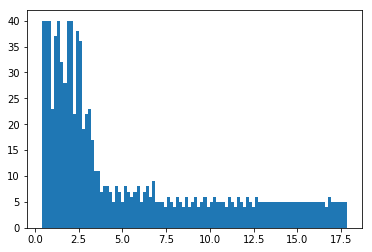

In [3]:
from flask import Flask
flask_app = Flask(__name__)
import time

@flask_app.route("/<name>")
def hello(name):
    time.sleep(0.1)
    return "Hello World!"

import asyncio
loop = asyncio.get_event_loop()
with app_running(lambda: flask_app, "sync", threads=10):
    stats = loop.run_until_complete(benchmark())
    
import matplotlib.pyplot as plt

print(stats.elapsed_time)
plt.hist(stats.request_latencies, bins=100)